In [1]:
!git clone https://github.com/farukcankaya/DeepImageBlending.git

Cloning into 'DeepImageBlending'...
remote: Enumerating objects: 186, done.
remote: Total 186 (delta 0), reused 0 (delta 0), pack-reused 186
Receiving objects: 100% (186/186), 35.51 MiB | 14.08 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [21]:
%cd "DeepImageBlending"

/content/DeepImageBlending


In [23]:
!python --version

Python 3.7.13


In [24]:
!pip install Pillow matplotlib numpy scikit-image torch opencv-python-headless torchvision aiohttp async-timeout

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47.8 MB 1.6 MB/s 
     |████████████████████████████████| 1.1 MB 30.8 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 144 kB 58.7 MB/s 
     |████████████████████████████████| 271 kB 75.3 MB/s 


In [25]:
!pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.4 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


In [31]:
# Packages
import pdb
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imsave
from utils import compute_gt_gradient, make_canvas_mask, numpy2tensor, laplacian_filter_tensor, \
                  MeanShift, Vgg16, gram_matrix

class Arguments:
    def __init__(self):
        self.source_file = 'data/1_source.png'
        self.mask_file = 'data/1_mask.png'
        self.target_file = 'data/1_target.png'
        self.ss = 300
        self.ts = 512
        self.x = 150 # Originally this was 200. So we shift the glas up
        self.y = 235
        self.gpu_id = 0
        self.num_steps = 1000
opt = Arguments()

# Inputs
source_file = opt.source_file
mask_file = opt.mask_file
target_file = opt.target_file

# Hyperparameter Inputs
gpu_id = opt.gpu_id
num_steps = opt.num_steps
ss = opt.ss # source image size
ts = opt.ts # target image size
x_start = opt.x; y_start = opt.y # blending location

device = f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


In [32]:
###################################
########### First Pass ###########
###################################

# Default weights for loss functions in the first pass
grad_weight = 1e4; style_weight = 1e4; content_weight = 1; tv_weight = 1e-6

# Load Images
source_img = np.array(Image.open(source_file).convert('RGB').resize((ss, ss)))
target_img = np.array(Image.open(target_file).convert('RGB').resize((ts, ts)))
mask_img = np.array(Image.open(mask_file).convert('L').resize((ss, ss)))
mask_img[mask_img>0] = 1

# Make Canvas Mask
canvas_mask = make_canvas_mask(x_start, y_start, target_img, mask_img)
canvas_mask = numpy2tensor(canvas_mask, device)
canvas_mask = canvas_mask.squeeze(0).repeat(3,1).view(3,ts,ts).unsqueeze(0)

In [33]:
imgshw = canvas_mask.squeeze().transpose(0, 2).transpose(0, 1).detach().cpu().numpy()

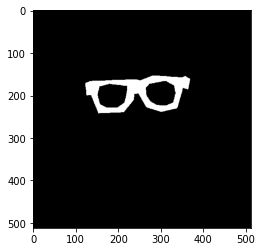

In [34]:
plt.imshow(imgshw)
plt.show()

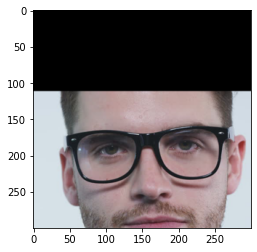

In [35]:
plt.imshow(source_img)
plt.show()

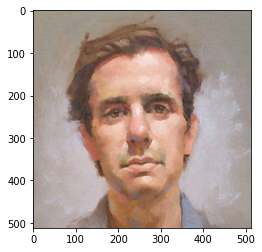

In [36]:
plt.imshow(target_img)
plt.show()

In [37]:
# Compute Ground-Truth Gradients
gt_gradient = compute_gt_gradient(x_start, y_start, source_img, target_img, mask_img, device)

# Convert Numpy Images Into Tensors
source_img = torch.from_numpy(source_img).unsqueeze(0).transpose(1,3).transpose(2,3).float().to(device)
target_img = torch.from_numpy(target_img).unsqueeze(0).transpose(1,3).transpose(2,3).float().to(device)
input_img = torch.randn(target_img.shape).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


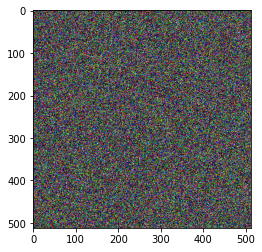

In [38]:
plt.imshow(input_img.squeeze().transpose(0, 2).transpose(0, 1).detach().cpu().numpy())
plt.show()

In [39]:
mask_img = numpy2tensor(mask_img, device)
mask_img = mask_img.squeeze(0).repeat(3,1).view(3,ss,ss).unsqueeze(0)

# Define LBFGS optimizer
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer
optimizer = get_input_optimizer(input_img)

# Define Loss Functions
mse = torch.nn.MSELoss()

# Import VGG network for computing style and content loss
mean_shift = MeanShift(device)
vgg = Vgg16().to(device)

run = [0]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [40]:
num_steps=1000
while run[0] <= num_steps:
    
    def closure():
        # Composite Foreground and Background to Make Blended Image
        blend_img = torch.zeros(target_img.shape).to(device)
        blend_img = input_img*canvas_mask + target_img*(canvas_mask-1)*(-1) 
        
        # Compute Laplacian Gradient of Blended Image
        pred_gradient = laplacian_filter_tensor(blend_img, device)
        
        # Compute Gradient Loss
        grad_loss = 0
        for c in range(len(pred_gradient)):
            grad_loss += mse(pred_gradient[c], gt_gradient[c])
        grad_loss /= len(pred_gradient)
        grad_loss *= grad_weight
        
        # Compute Style Loss
        target_features_style = vgg(mean_shift(target_img))
        target_gram_style = [gram_matrix(y) for y in target_features_style]
        
        blend_features_style = vgg(mean_shift(input_img))
        blend_gram_style = [gram_matrix(y) for y in blend_features_style]
        
        style_loss = 0
        for layer in range(len(blend_gram_style)):
            style_loss += mse(blend_gram_style[layer], target_gram_style[layer])
        style_loss /= len(blend_gram_style)  
        style_loss *= style_weight           

        
        # Compute Content Loss
        blend_obj = blend_img[:,:,int(x_start-source_img.shape[2]*0.5):int(x_start+source_img.shape[2]*0.5), int(y_start-source_img.shape[3]*0.5):int(y_start+source_img.shape[3]*0.5)]
        source_object_features = vgg(mean_shift(source_img*mask_img))
        blend_object_features = vgg(mean_shift(blend_obj*mask_img))
        content_loss = content_weight * mse(blend_object_features.relu2_2, source_object_features.relu2_2)
        content_loss *= content_weight
        
        # Compute TV Reg Loss
        tv_loss = torch.sum(torch.abs(blend_img[:, :, :, :-1] - blend_img[:, :, :, 1:])) + \
                   torch.sum(torch.abs(blend_img[:, :, :-1, :] - blend_img[:, :, 1:, :]))
        tv_loss *= tv_weight
        
        # Compute Total Loss and Update Image
        loss = grad_loss + style_loss + content_loss + tv_loss
        optimizer.zero_grad()
        loss.backward()
        
        # Print Loss
        if run[0] % 1 == 0:
            print("run {}:".format(run))
            print('grad : {:4f}, style : {:4f}, content: {:4f}, tv: {:4f}'.format(\
                          grad_loss.item(), \
                          style_loss.item(), \
                          content_loss.item(), \
                          tv_loss.item()
                          ))
            print()
        
        run[0] += 1
        return loss
    
    optimizer.step(closure)

run [0]:
grad : 3380656.750000, style : 251125728.000000, content: 8003.238281, tv: 5.107119

run [1]:
grad : 3380648.250000, style : 251125728.000000, content: 8003.238281, tv: 5.107118

run [2]:
grad : 3380648.250000, style : 251125728.000000, content: 8003.238281, tv: 5.107118

run [3]:
grad : 443219456.000000, style : 323592672.000000, content: 186236.750000, tv: 14.958854

run [4]:
grad : 1486867.375000, style : 250790272.000000, content: 6230.801758, tv: 5.364429

run [5]:
grad : 1130484.500000, style : 250079280.000000, content: 5544.323242, tv: 5.477978

run [6]:
grad : 22250872832.000000, style : 3018722902016.000000, content: 19009576.000000, tv: 103.814636

run [7]:
grad : 1119195.750000, style : 250066560.000000, content: 5543.247070, tv: 5.477083

run [8]:
grad : 1109031.500000, style : 250053920.000000, content: 5541.551758, tv: 5.476595

run [9]:
grad : 1931106.875000, style : 248856096.000000, content: 5430.260254, tv: 5.623445

run [10]:
grad : 1587346.250000, style : 

In [41]:
# clamp the pixels range into 0 ~ 255
input_img.data.clamp_(0, 255)

# Make the Final Blended Image
blend_img = torch.zeros(target_img.shape).to(device)
blend_img = input_img*canvas_mask + target_img*(canvas_mask-1)*(-1) 
blend_img_np = blend_img.transpose(1,3).transpose(1,2).cpu().data.numpy()[0]

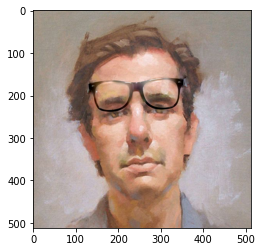

In [42]:
plt.imshow(blend_img_np.astype(np.uint8))
plt.show()

In [43]:
# Save image from the first pass
name = source_file.split('/')[1].split('_')[0]
imsave('results/'+str(name)+'_first_pass.png', blend_img_np.astype(np.uint8))

In [44]:


###################################
########### Second Pass ###########
###################################

# Default weights for loss functions in the second pass
style_weight = 1e7; content_weight = 1; tv_weight = 1e-6
ss = 512; ts = 512
num_steps = opt.num_steps

first_pass_img_file = 'results/'+str(name)+'_first_pass.png'
first_pass_img = np.array(Image.open(first_pass_img_file).convert('RGB').resize((ss, ss)))
target_img = np.array(Image.open(target_file).convert('RGB').resize((ts, ts)))
first_pass_img = torch.from_numpy(first_pass_img).unsqueeze(0).transpose(1,3).transpose(2,3).float().to(device)
target_img = torch.from_numpy(target_img).unsqueeze(0).transpose(1,3).transpose(2,3).float().to(device)

# Define LBFGS optimizer
def get_input_optimizer(first_pass_img):
    optimizer = optim.LBFGS([first_pass_img.requires_grad_()])
    return optimizer

optimizer = get_input_optimizer(first_pass_img)

print('Optimizing...')
run = [0]
while run[0] <= num_steps:
    
    def closure():
        
        # Compute Loss Loss    
        target_features_style = vgg(mean_shift(target_img))
        target_gram_style = [gram_matrix(y) for y in target_features_style]
        blend_features_style = vgg(mean_shift(first_pass_img))
        blend_gram_style = [gram_matrix(y) for y in blend_features_style]
        style_loss = 0
        for layer in range(len(blend_gram_style)):
            style_loss += mse(blend_gram_style[layer], target_gram_style[layer])
        style_loss /= len(blend_gram_style)  
        style_loss *= style_weight        
        
        # Compute Content Loss
        content_features = vgg(mean_shift(first_pass_img))
        content_loss = content_weight * mse(blend_features_style.relu2_2, content_features.relu2_2)
        
        # Compute Total Loss and Update Image
        loss = style_loss + content_loss
        optimizer.zero_grad()
        loss.backward()
        
        # Print Loss
        if run[0] % 1 == 0:
            print("run {}:".format(run))
            print(' style : {:4f}, content: {:4f}'.format(\
                          style_loss.item(), \
                          content_loss.item()
                          ))
            print()
        
        run[0] += 1
        return loss
    
    optimizer.step(closure)

# clamp the pixels range into 0 ~ 255
first_pass_img.data.clamp_(0, 255)

# Make the Final Blended Image
input_img_np = first_pass_img.transpose(1,3).transpose(1,2).cpu().data.numpy()[0]



Optimizing...
run [0]:
 style : 47441312.000000, content: 0.000000



RuntimeError: ignored

In [ ]:
# Save image from the second pass
imsave('results/'+str(name)+'_second_pass.png', input_img_np.astype(np.uint8))